### M/M/1 vs M/M/2
##### Imports



In [206]:
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = "serif"     
rcParams['font.size'] = 16
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

### Theoretical waiting times

In [4]:
def erlang_c(c, rho):
    
    # Calculate the Erlang C formula
    numerator = (c * rho)**c / (np.math.factorial(c) * (1 - rho))
    denominator = sum((c * rho)**k / np.math.factorial(k) for k in range(c)) + numerator

    return numerator / denominator

def calculate_waiting_time(c, lambda_, mu):
    # Calculate the average waiting time in an M/M/c queue
    rho = lambda_ / (c * mu)
    
    if rho >= 1:
        return float('inf')  # System is unstable

    # Calculate Erlang C formula
    C_c_rho = erlang_c(c, rho)

    # Correct formula for average waiting time in queue
    W_q = C_c_rho / (c * mu - lambda_)
    W = W_q + 1 / mu

    # Return only the waiting time in the queue
    return W_q

# Test the function with the provided values
calculate_waiting_time(2, 1.8, 1)

4.263157894736843

### General M/M/n queue

In [51]:
# This function defines the customer arrivals at the queue.
def arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        # Calculate the time it takes to help the customer.
        tis = random.expovariate(mu)
        yield env.timeout(tis)


# Runs the simulation N times for a certain number of servers.
def run_simulation(num_servers, N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [ ]:
# Parameters
lambda_ = .99  # arrival rate 
mu = 1  # service rate
sim_time = 10000 
N = 10   

# Run simulations for different numbers of servers and calculate average waiting time.
MMn_res = {}
for n in [1,2,4]:
    avg_wait = run_simulation(n, N, lambda_, mu, sim_time)
    MMn_res[n] = avg_wait
    print(f"System load: {lambda_ / (n * mu):.2f}")
    print(f'Average waiting time for M/M/{n}: {avg_wait:.2f}')

System load: 0.99
Average waiting time for M/M/1: 119.54
System load: 0.49
Average waiting time for M/M/2: 0.34
System load: 0.25
Average waiting time for M/M/4: 0.01


### Priority M/M/1

In [50]:
# This function defines the customer arrivals at the queue.
def priority_arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = priority_customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)


# This function defines the process every customer goes through.
def priority_customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # Calculate the time it takes to help the customer.
    tis = random.expovariate(mu)
    # The customer requests a counter and receives priority for shorter service time
    with counter.request(priority=tis, preempt=False) as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        yield env.timeout(tis)

    
# Simulations of priority M/M/1 queue
def run_priority_simulation(N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.PreemptiveResource(env, capacity=1)
        # Start the arrival process.
        env.process(priority_arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
        
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [57]:
# Parameters
lambda_ = 0.9 # arrival rate 
mu = 1  # service rate
sim_time = 5000
N = 1

# Run simulations for priority queue with 1 server and calculate average waiting time.
MM1_res = run_priority_simulation(N, lambda_, mu, sim_time)
print(f"System load: {lambda_ / (1 * mu):.2f}")
print(f'Average waiting time for M/M/1: {MM1_res:.2f}')

System load: 0.90
Average waiting time for M/M/1: 3.37


### Comparison priority and normal M/M/1

In [183]:

def collect_simulation_data(N, mu, sim_time, lambda_values):
    mm1_res = []
    mm1_errors = []
    avg_wait = []
    avg_wait_errors = []

    for lambda_ in lambda_values:
        print(f"Running simulation for lambda = {lambda_:.2f}")
        # Run M/M/1 with priority scheduling
        priority_results = [run_priority_simulation(N, lambda_, mu, sim_time) for _ in range(N)]
        mm1_res.append(np.mean(priority_results))
        mm1_errors.append(np.std(priority_results) / np.sqrt(N))

        # Run standard M/M/1
        standard_results = [run_simulation(1, N, lambda_, mu, sim_time) for _ in range(N)]
        avg_wait.append(np.mean(standard_results))
        avg_wait_errors.append(np.std(standard_results) / np.sqrt(N))

    return lambda_values, mm1_res, mm1_errors, avg_wait, avg_wait_errors

# Parameters for the simulation
N = 20  # Number of runs for each value of lambda
mu = 1  # Service rate
sim_time = 1000  # Simulation time
lambda_values = np.linspace(0.1, 0.99, 15)  # Range of arrival rates

# Collect data
data_comparison = collect_simulation_data(N, mu, sim_time, lambda_values)

Running simulation for lambda = 0.10
Running simulation for lambda = 0.16
Running simulation for lambda = 0.23
Running simulation for lambda = 0.29
Running simulation for lambda = 0.35
Running simulation for lambda = 0.42
Running simulation for lambda = 0.48
Running simulation for lambda = 0.55
Running simulation for lambda = 0.61
Running simulation for lambda = 0.67
Running simulation for lambda = 0.74
Running simulation for lambda = 0.80
Running simulation for lambda = 0.86
Running simulation for lambda = 0.93
Running simulation for lambda = 0.99


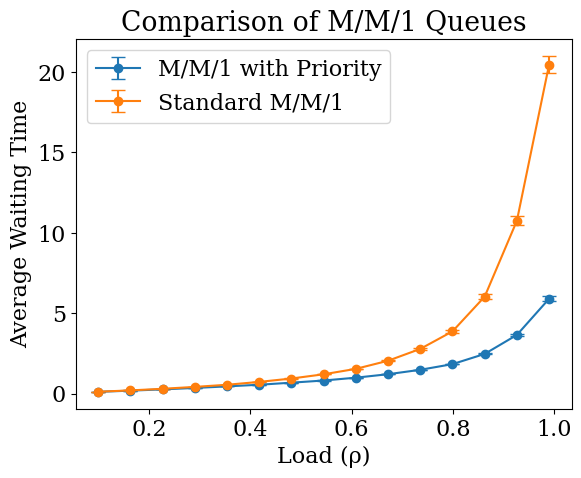

In [207]:

lambda_values, mm1_res, mm1_errors, avg_wait, avg_wait_errors = data_comparison

plt.errorbar(lambda_values, mm1_res, yerr=mm1_errors, label='M/M/1 with Priority', fmt='-o', capsize=5)
plt.errorbar(lambda_values, avg_wait, yerr=avg_wait_errors, label='Standard M/M/1', fmt='-o', capsize=5)

plt.xlabel('Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.title('Comparison of M/M/1 Queues')
plt.legend()
plt.savefig('MM1_prio_comparison.png', dpi=400)
plt.show()


### M/D/n

In [59]:
SERVICE_TIME = 1

# This function defines the customer arrivals at the queue.
def mdn_arrivals(env, n, interval, counter, waiting_times, mu):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = mdn_customer(env, f'Customer{i}', counter, waiting_times, mu)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def mdn_customer(env, name, counter, time_in_system, mu):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        yield env.timeout(SERVICE_TIME)


# Runs the simulation N times for a certain number of servers.
def run_mdn_simulation(num_servers, N, lambda_, mu, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(mdn_arrivals(env, sim_time, lambda_, counter, waiting_times, mu))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [9]:
# Parameters
lambda_ = .99  # arrival rate 
mu = 1  # service rate
sim_time = 10000 
N = 10   

# Run simulations for different numbers of servers and calculate average waiting time.
MDn_res = {}
for n in [1,2,4]:
    avg_wait = run_mdn_simulation(n, N, lambda_, mu, sim_time)
    MDn_res[n] = avg_wait
    print(f"System load: {lambda_ / (n * mu):.2f}")
    print(f'Average waiting time for M/D/{n}: {avg_wait:.2f}')

System load: 0.99
Average waiting time for M/D/1: 76.35
System load: 0.49
Average waiting time for M/D/2: 0.19
System load: 0.25
Average waiting time for M/D/4: 0.00


### Hyper-exponential distribution

In [58]:
# This function defines the customer arrivals at the queue.
def hpx_arrivals(env, n, interval, counter, waiting_times, service_times):
    # Generate n arrivals to the counter.
    for i in range(n):
        # Generate a 'customer' process.
        c = hpx_customer(env, f'Customer{i}', counter, waiting_times, service_times)
        # Add it to the environment.
        env.process(c)
        # Calculate the time to the next arrival.
        t = random.expovariate(interval)
        # Pause the 'arrivals' process, simulating waiting time.
        yield env.timeout(t)

# This function defines the process every customer goes through.
def hpx_customer(env, name, counter, time_in_system, service_times):
    # Logs the arrival time of the customer.
    arrive = env.now
    # The customer requests a counter.
    with counter.request() as req:
        # Wait for the counter to be available.
        yield req
        # Calculate the time the customer waited and append.
        wait = env.now - arrive
        time_in_system.append(wait)
        # Select service time
        tis = service_times.pop()
        yield env.timeout(tis)

def hyperexp_service_times(probability, time0, time1, size):
    # Generate samples to assign to phases
    samples = np.random.uniform(size=size)
    
    # Determine which phase each sample belongs to based on the given probability
    phase = np.where(samples < probability, 0, 1)
    
    # Generate samples based on the selected phase
    times = np.where(phase == 0, np.random.exponential(scale=time0, size=size),
                       np.random.exponential(scale=time1, size=size))
    
    return list(times)

# Runs the simulation N times for a certain number of servers.
def run_hpx_simulation(num_servers, N, lambda_, hyper_exp, sim_time):
    waiting_times = []
    # Run the simulation N times.
    for _ in range(N):
        # Generate service times
        service_times = hyperexp_service_times(*hyper_exp)
        # Set timeline and manage scheduling and processing of events.
        env = simpy.Environment()
        # Make the counter with a certain number of servers.
        counter = simpy.Resource(env, capacity=num_servers)
        # Start the arrival process.
        env.process(hpx_arrivals(env, sim_time, lambda_, counter, waiting_times, service_times))
        # Run the simulation until events are handled or time runs out.
        env.run()
    # Calculate average waiting time.
    average_wait = np.mean(waiting_times)
    return average_wait

In [11]:
# probability of belonging to phase 0 
probability = 0.75

# average waiting time for both phases
time0 = 1.0
time1 = 5.0  

# Parameters
lambda_ = 2  # arrival rate 
mu = probability*time0 + (1-probability)*time1
sim_time = 10000 
N = 10  
hyper_exp = [probability, time0, time1, sim_time]

MHn_res = {}
for n in [1,2,4]:
    avg_wait = run_hpx_simulation(n, N, lambda_, hyper_exp, sim_time)
    MHn_res[n] = avg_wait
    print(f"System load: {lambda_ / (n * mu):.2f}")
    print(f'Average waiting time for M/H/{n}: {avg_wait:.2f}')

System load: 1.00
Average waiting time for M/H/1: 281.81
System load: 0.50
Average waiting time for M/H/2: 1.16
System load: 0.25
Average waiting time for M/H/4: 0.02


### Erlang-k distribution?

### Data generation and visualisation.



In [41]:

def has_reached_steady_state(num_servers, lambda_, mu, total_sim_time, interval=100, threshold=0.03, min_intervals=3):
    last_avg_wait = None
    stable_intervals = 0

    for start_time in range(0, total_sim_time, interval):
        sim_time = start_time + interval
        average_wait = run_simulation(num_servers, 100, lambda_, mu, sim_time)  
        print(f"Average waiting time for M/M/{num_servers} at time {sim_time}: {average_wait:.2f}")
        if last_avg_wait is not None:
            change = abs((average_wait - last_avg_wait) / last_avg_wait)
            if change < threshold:
                stable_intervals += 1
            else:
                stable_intervals = 0

            if stable_intervals >= min_intervals:

                return sim_time # Steady state reached

        last_avg_wait = average_wait

    return False  # Steady state not reached within the total simulation time

# Seems like it takes longer for the M/M/1 queue with high load to reach steady state
steady_state_reached = has_reached_steady_state(1, 0.9, 1, 10000)
print("Steady state for M/M/1 and lambda = 0.9 reached at time:", steady_state_reached)

# Seems like a M/M/2 queue with high load reaches steady state faster than a M/M/1 queue
steady_state_reached = has_reached_steady_state(2, 1.8, 1, 10000)
print("Steady state for M/M/2 and lambda = 0.9 reached at time:", steady_state_reached)



Average waiting time for M/M/1 at time 100: 8.60
Average waiting time for M/M/1 at time 200: 15.86
Average waiting time for M/M/1 at time 300: 18.23
Average waiting time for M/M/1 at time 400: 26.99
Average waiting time for M/M/1 at time 500: 31.21
Average waiting time for M/M/1 at time 600: 36.56
Average waiting time for M/M/1 at time 700: 42.56
Average waiting time for M/M/1 at time 800: 47.30
Average waiting time for M/M/1 at time 900: 52.44
Average waiting time for M/M/1 at time 1000: 57.42
Average waiting time for M/M/1 at time 1100: 59.09
Average waiting time for M/M/1 at time 1200: 70.18
Average waiting time for M/M/1 at time 1300: 72.48
Average waiting time for M/M/1 at time 1400: 77.13
Average waiting time for M/M/1 at time 1500: 82.58
Average waiting time for M/M/1 at time 1600: 85.62
Average waiting time for M/M/1 at time 1700: 90.58
Average waiting time for M/M/1 at time 1800: 97.90
Average waiting time for M/M/1 at time 1900: 105.95
Average waiting time for M/M/1 at time 2

In [101]:

def generate_data(lambda_values):
    
    mu = 1  
    N = 100  # Number of runs for each lambda
    sim_time = 2000

    data = {}

    for n in [1, 2, 4]:
        theoretical = []
        simulated_means = []
        simulated_errors = []

        for lambda_ in lambda_values:
            load = lambda_ / (n * mu)
            if load < 1:  # Only run simulations for stable systems
                theoretical.append(calculate_waiting_time(n, lambda_, mu))

                # Collect multiple waiting times for each lambda
                simulated_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(N)]
                mean_time = np.mean(simulated_times)
                error = np.std(simulated_times) / np.sqrt(N)  # Standard Error

                simulated_means.append(mean_time)
                simulated_errors.append(error)
            else:
                theoretical.append(float('inf'))
                simulated_means.append(float('inf'))
                simulated_errors.append(0)  # No error for unstable systems

        data[n] = {
            'lambda': lambda_values, 
            'theoretical': theoretical, 
            'simulated_means': simulated_means,
            'simulated_errors': simulated_errors
        }

    return data


def generate_data_load(load_values):
    
    mu = 1  
    N = 1  # Number of runs for each lambda
    sim_time = 1500

    data = {}

    for n in [1, 2, 4]:
        theoretical = []
        simulated_means = []
        simulated_errors = []

        for load in load_values:
            lambda_ = load * n * mu
            
            theoretical.append(calculate_waiting_time(n, lambda_, mu))

            # Collect multiple waiting times for each lambda
            simulated_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(N)]
            mean_time = np.mean(simulated_times)
            error = np.std(simulated_times) / np.sqrt(N)  # Standard Error

            simulated_means.append(mean_time)
            simulated_errors.append(error)

        data[n] = {
            'load': load_values, 
            'theoretical': theoretical, 
            'simulated_means': simulated_means,
            'simulated_errors': simulated_errors
        }

    return data

# lambda_values = np.linspace(0.1, 3.1, 30)
# data_normal_1  = generate_data(lambda_values)
load_values = np.linspace(0.05, 0.99, 30)
data_normal_2  = generate_data_load(load_values)



[1.123815095212379e-06, 1.0564167914890418e-05, 1.3525161204604665e-05, 3.160531735927985e-05, 5.338517186165359e-05, 8.798953249840967e-05, 0.00011454465474179134, 0.00015642439020688523, 0.00022943924122263018, 0.0003044991462757798, 0.0004195675602280043, 0.0005126424248040017, 0.0006136935315087436, 0.0008445019303736319, 0.0009983531293372492, 0.0011774795539149468, 0.0014546916328675066, 0.0013164979837391587, 0.0017109052732074965, 0.0022016710358270107, 0.003193618079149541, 0.004145725530595504, 0.004567199674225352, 0.00397824505134039, 0.005955217535209676, 0.007650819901599755, 0.0099305267931818, 0.01076291419227628, 0.019961170154512597, 0.017397348801664634]


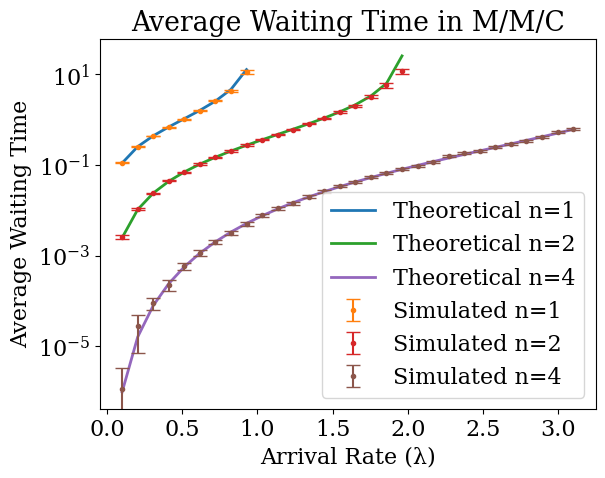

In [209]:
confidence_level = 1.96  # For a 95% confidence interval

for n, values in data_normal_1.items():
    if n != 6:
        # Plot theoretical values
        plt.plot(values['lambda'], values['theoretical'], label=f"Theoretical n={n}", linewidth=2)

        # Calculate the confidence interval
        ci = [error * confidence_level for error in values['simulated_errors']]

        # Plot simulated values with confidence intervals
        plt.errorbar(values['lambda'], values['simulated_means'], yerr=ci, 
                        label=f"Simulated n={n}", fmt='o', capsize=5,markersize=3)

print(data_normal_1[4]['simulated_errors'])
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time in M/M/C')
plt.yscale('log')
plt.legend()
plt.savefig('Wait_vs_Theory.png', dpi=400)
plt.show()



In [132]:
def calculate_relative_error(standard_deviation, mean):
    if mean != 0:
        return standard_deviation / mean
    else:
        return float('inf')  # or handle as a special case

from scipy import stats

def generate_load_impact_data(num_servers, mu, num_runs, sim_time, load_levels):
    data = {}

    for n in num_servers:
        variances = []
        means = []
        print(f"Running simulations for M/M/{n}")
        for load in load_levels:
            lambda_ = load * n * mu  # Set lambda to achieve the desired load
            waiting_times = [run_simulation(n, 1, lambda_, mu, sim_time) for _ in range(num_runs)]
            means.append(np.mean(waiting_times))
            variances.append(np.std(waiting_times))

        relative_error = [calculate_relative_error(sd, mean) for sd, mean in zip(variances, means)]
        data[n] = {'load_levels': load_levels, 'variances': variances, 'relative_error': relative_error}
    
    return data

# Example usage
num_servers = [1,2,4]
mu = 1
num_runs = 100
sim_time = 1000
load_levels = np.linspace(0.1, 0.999, 100)
data_variance = generate_load_impact_data(num_servers, mu, num_runs, sim_time, load_levels)

Running simulations for M/M/1


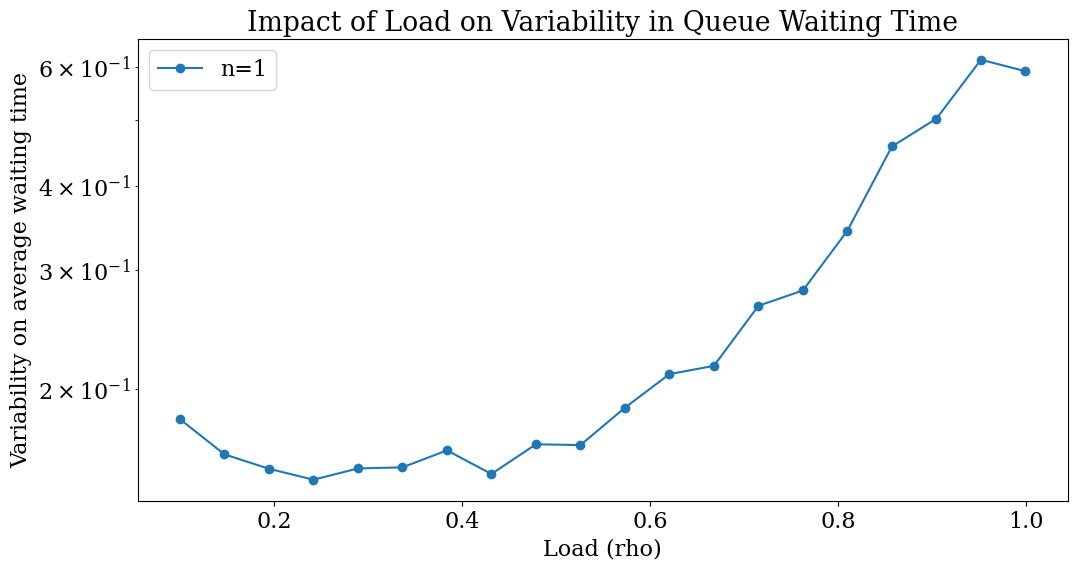

In [133]:
plt.figure(figsize=(12, 6))
for n, values in data_variance.items():
    # plt.plot(values['load_levels'], values['variances'], label=f'n={n}', marker='o')
    plt.plot(values['load_levels'], values['relative_error'], label=f'n={n}', marker='o')

plt.xlabel('Load (rho)')
plt.ylabel('Variability on average waiting time')
plt.title('Impact of Load on Variability in Queue Waiting Time')
plt.yscale('log')
plt.legend()
plt.show()

In [174]:
from scipy import stats


def test_runs_needed_for_significance(mu, c, sim_time, target_confidence):
    load_levels = np.linspace(0.1, 0.95, 40)  # Varying load from 0.1 to just below 1
    runs_needed = np.zeros(len(load_levels))
    i = 0
    for rho in load_levels:
        print(rho)
        lambda_ = rho * c * mu
        runs = 0
        achieved_confidence = False
        
        while not achieved_confidence and runs <= 10000:
            results = [run_simulation(c, 1, lambda_, mu, sim_time) for _ in range(20)]
            runs += 20
            mean_result, std_dev = np.mean(results), np.std(results)
            achieved_confidence = check_confidence(mean_result, std_dev, runs, target_confidence)
            
        
        runs_needed[i] = runs
        i += 1
    return load_levels, runs_needed


def check_confidence(mean, std_dev, n, target_confidence):

    # Calculate the t-score for the given confidence level and sample size
    t_score = stats.t.ppf(1 - (1 - target_confidence) / 2, df=n-1)

    # Calculate the margin of error
    margin_of_error = t_score * (std_dev / np.sqrt(n))

    # Calculate the width of the confidence interval
    confidence_interval_width = margin_of_error * 2

    # Define a threshold for what you consider 'narrow enough'
    # So we are 95% confident that the mean is within 0.1 of the sample mean
    
    threshold = 0.1 * abs(mean)

    return confidence_interval_width < threshold


# Running the test
mu = 1  # Fixed service rate
c = 1  # Number of servers (for M/M/1)
sim_time = 1000  # Simulation time for each run
target_confidence = 0.98  # Desired confidence level

runs_needed_average = np.zeros(40)
for i in range(10):
    load_levels, runs_needed = test_runs_needed_for_significance(mu, c, sim_time, target_confidence)

    runs_needed_average = runs_needed_average + runs_needed/10



0.1
0.1217948717948718
0.14358974358974358
0.16538461538461538
0.18717948717948718
0.20897435897435898
0.23076923076923075
0.25256410256410255
0.2743589743589744
0.29615384615384616
0.31794871794871793
0.33974358974358976
0.3615384615384615
0.3833333333333333
0.40512820512820513
0.42692307692307696
0.4487179487179487
0.4705128205128205
0.49230769230769234
0.514102564102564
0.5358974358974359
0.5576923076923077
0.5794871794871794
0.6012820512820513
0.623076923076923
0.6448717948717948
0.6666666666666666
0.6884615384615385
0.7102564102564102
0.732051282051282
0.7538461538461538
0.7756410256410255
0.7974358974358974
0.8192307692307692
0.8410256410256409
0.8628205128205128
0.8846153846153846
0.9064102564102563
0.9282051282051281
0.95
0.1
0.1217948717948718
0.14358974358974358
0.16538461538461538
0.18717948717948718
0.20897435897435898
0.23076923076923075
0.25256410256410255
0.2743589743589744
0.29615384615384616
0.31794871794871793
0.33974358974358976
0.3615384615384615
0.3833333333333333


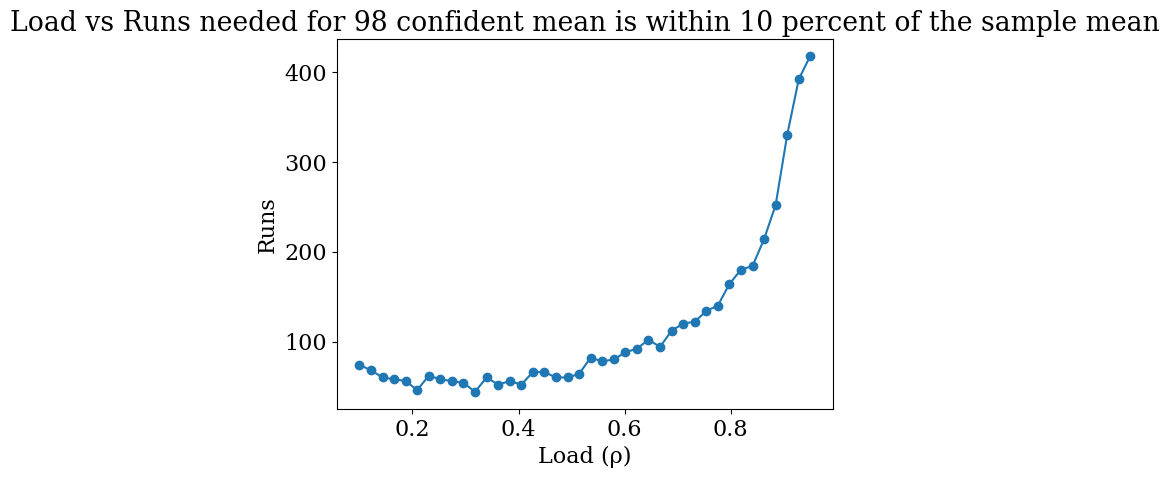

In [176]:
# Plotting the results

plt.plot(load_levels, runs_needed_average, marker='o')
plt.xlabel('Load (ρ)')
plt.ylabel('Runs')
#plt.yscale('log')
plt.title('Load vs Runs needed for 98 confident mean is within 10 percent of the sample mean')
plt.savefig('Load_vs_Runs.png', dpi=400)
plt.show()

In [67]:
def generate_distribution_data():
    lambda_values = np.linspace(0.1, 3.1, 30)
    mu = 1
    N = 100
    sim_time = 2000
    hyper_exp_params = (0.75, 1.0, 5.0, sim_time)

    data = {}

    for n in [1, 2, 4, 6]:
        mdn_results = []
        hpx_results = []
        for lambda_ in lambda_values:
            load = lambda_ / (n * mu)
            if load < 1:  # Only run simulations for stable systems
                mdn_results.append(run_mdn_simulation(n, N, lambda_, mu, sim_time))
                hpx_results.append(run_hpx_simulation(n, N, lambda_, hyper_exp_params, sim_time))
            else:
                mdn_results.append(float('inf'))
                hpx_results.append(float('inf'))

        data[n] = {'lambda': lambda_values, 'mdn': mdn_results, 'hpx': hpx_results}

    return data

mdn_hpx_data = generate_distribution_data()

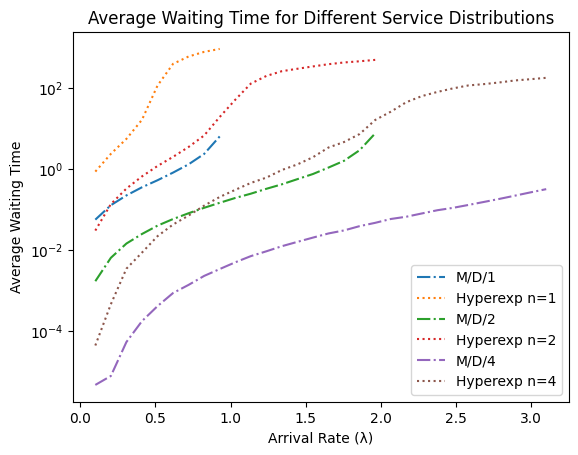

In [68]:

for n, values in mdn_hpx_data.items():
    plt.plot(values['lambda'], values['mdn'], label=f"M/D/{n}", linestyle='-.')
    plt.plot(values['lambda'], values['hpx'], label=f"Hyperexp n={n}", linestyle=':')


plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time for Different Service Distributions')
plt.yscale('log')
plt.legend()
plt.show()